## Let's make a linear model 
We will use mean square error instead of SMAPE

In [1]:
# Importing helpful libraries
import pandas as pd
import numpy as np
import pickle
import itertools
import gc
import math
import matplotlib.pyplot as plt
import dateutil.easter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from datetime import datetime, date
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder, minmax_scale
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, HuberRegressor, SGDRegressor
from sklearn.svm import SVR, LinearSVR

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the dataset 
original_train_df = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv')
original_test_df = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv')

In [3]:
# Since dates are read as strings, we will need to convert it into datetime series 
for df in [original_train_df,original_test_df]:
    df['date'] = pd.to_datetime(df.date)
    df.set_index('date', inplace= True, drop= False)
original_train_df.head(2)

,row_id,date,country,store,product,num_sold
date,,,,,,
2015-01-01,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
2015-01-01,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520


In [4]:
def smape_loss(y_true, y_pred):
    """SMAPE Loss to be used with TensorFlow"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200


## Feature Engineering  

In [5]:
def feature_engineering(df):
    new_df = pd.DataFrame({'daynum':            (df.date - datetime(2015,1,1)).dt.days,
                           'dayofyear':          df.date.dt.dayofyear,
                           'wd1': df.date.dt.weekday == 1,
                           'wd2': df.date.dt.weekday == 2,
                           'wd3': df.date.dt.weekday == 3,
                           'wd4': df.date.dt.weekday == 4,
                           'wd5': df.date.dt.weekday == 5,
                           'wd6': df.date.dt.weekday == 6,
                           #'dec26': (df.date.dt.month == 12) & (df.date.dt.day == 29),
                           'dec27': (df.date.dt.month == 12) & (df.date.dt.day == 29),
                           'dec28': (df.date.dt.month == 12) & (df.date.dt.day == 29),
                           'dec29': (df.date.dt.month == 12) & (df.date.dt.day == 29),
                           'dec30': (df.date.dt.month == 12) & (df.date.dt.day == 30),
                           #'dec31': (df.date.dt.month == 12) & (df.date.dt.day == 30),
                           #'yearend': df.date.dt.dayofyear >= 360,
                           #'dec30': (df.date.dt.month == 12) & (df.date.dt.day == 30),
                           'easter': 0,
                           'easter1': 0,
                           'easter2': 0,
                           'easter3': 0,
                          })
    new_df['daynum2'] = np.log(new_df.daynum + 80) 
    
     # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Sticker']:
        new_df[product] = df['product'] == product
    
    # Seasonal variations (Fourier series)
    for k in range(1,100):
        new_df[f'sin{k}'] = np.sin(new_df.dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(new_df.dayofyear / 365 * 2 * math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'sticker_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Sticker']
        new_df[f'sticker_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Sticker']
    
    return new_df
train_df = feature_engineering(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = feature_engineering(original_test_df)

features = test_df.columns
for df in [train_df, test_df]:
    df[features] = df[features].astype(np.float32)

display(train_df.info())
train_df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26298 entries, 2015-01-01 to 2018-12-31
Columns: 618 entries, daynum to num_sold
dtypes: datetime64[ns](1), float32(617)
memory usage: 62.3 MB


None

,daynum,dayofyear,wd1,wd2,wd3,wd4,wd5,wd6,dec27,dec28,...,sticker_sin98,sticker_cos98,sin99,cos99,mug_sin99,mug_cos99,sticker_sin99,sticker_cos99,date,num_sold
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.000000,0.991114,-0.133015,0.991114,-0.133015,0.000000,-0.000000,2015-01-01,329.0
2015-01-01,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.000000,0.991114,-0.133015,0.000000,-0.000000,0.000000,-0.000000,2015-01-01,520.0
2015-01-01,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.993257,-0.115935,0.991114,-0.133015,0.000000,-0.000000,0.991114,-0.133015,2015-01-01,146.0


Fold 0.0
(6552, 1) (6552, 1)
Fold 0.0 | 00:13 | SMAPE: 6.27316 5.62331


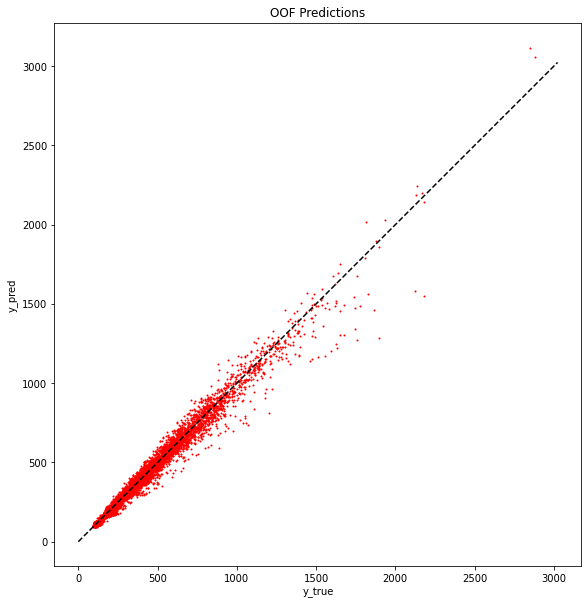

Fold 1.0
(6552, 1) (6552, 1)
Fold 1.0 | 00:13 | SMAPE: 6.27316 5.62331


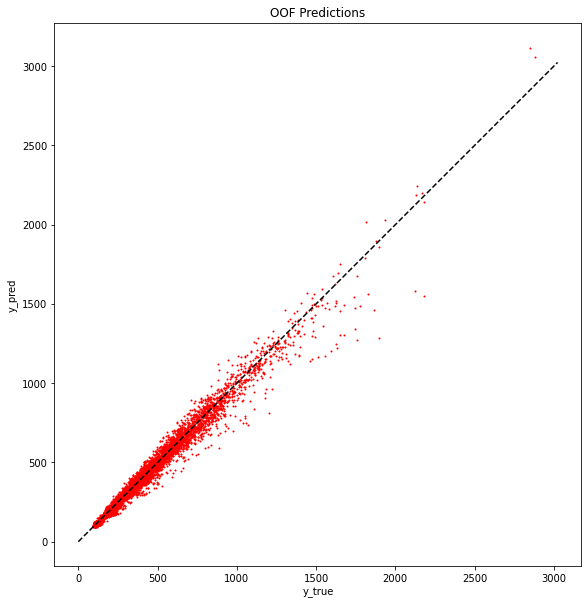

CPU times: user 1min 40s, sys: 1min 47s, total: 3min 28s
Wall time: 54.7 s


In [6]:
%%time
RUNS = 2 # should be 1. increase the number of runs only if you want see how the result depends on the random seed
INFERENCE = True
OUTLIERS = None

def fit_model(X_tr, X_va=None):
    """Scale the data, fit a model, plot the training history and validate the model"""
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    validation_data = None

    if X_va is not None:
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)
        validation_data = (X_va_f, y_va)

    # Train and save the model
    model = HuberRegressor(epsilon=1.35) # 6.27316 5.62331 (1.35) ******************
    #model = LinearRegression() # 6.31480 5.73797
    model.fit(X_tr_f, np.log(y_tr))

    if X_va is not None:
        # Inference for validation after last epoch of fold
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        print(y_va_pred.shape, oof_list[run][val_idx].shape)
        oof_list[run][val_idx] = y_va_pred

        # Evaluation
        smape = np.mean(smape_loss(y_va, y_va_pred))
        smape_q1 = np.mean(smape_loss(y_va, y_va_pred)[(X_va.date.dt.month <= 3).values])
        score_list.append((smape, datetime.now() - start_time))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f} {smape_q1:.5f}")
        
        # Plot y_true vs. y_pred
        # Everything to the right of the black line is an outlier prediction which will be treated in a future version of the notebook
        plt.figure(figsize=(10, 10))
        plt.scatter(y_va, y_va_pred, s=1, color='r')
        plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], '--', color='k')
        if OUTLIERS != None:
            plt.plot([OUTLIERS, OUTLIERS+plt.ylim()[1]], [0, plt.ylim()[1]], color='k', lw=1)
        plt.gca().set_aspect('equal')
        plt.xlabel('y_true')
        plt.ylabel('y_pred')
        plt.title('OOF Predictions')
        plt.show()

        # Show the outliers among the predictions: Easter week, Pentecost week, last week of the year
        if OUTLIERS != None:
            print("Outlier predictions")
            print(original_train_df.iloc[val_idx][(y_va - y_va_pred > OUTLIERS).ravel()])
            #print("Outlier predictions")
            #print(X_va[(y_va_pred < 50).ravel()])
        
    return preproc, model


# Make the results reproducible
np.random.seed(202100)

total_start_time = datetime.now()
score_list, test_pred_list, history_list = [], [], []
oof_list = [np.full((len(train_df), 1), -1.0, dtype='float32') for run in range(RUNS)]
for run in range(RUNS):
    fold = 0
    train_idx = np.arange(len(train_df))[train_df.date < datetime(2018, 1, 1)]
    val_idx = np.arange(len(train_df))[train_df.date > datetime(2018, 1, 1)]
    print(f"Fold {run}.{fold}")
    start_time = datetime.now()
    X_tr = train_df.iloc[train_idx]
    X_va = train_df.iloc[val_idx]
    
    preproc, model = fit_model(X_tr, X_va)

if INFERENCE:
    fold = 999
    train_idx = np.arange(len(train_df))
    X_tr = train_df.iloc[train_idx]
    
    preproc, model = fit_model(X_tr, None)

    # Inference for test
    test_pred_list.append(np.exp(model.predict(preproc.transform(test_df[features]))))

# Save all oof and test predictions to later determine ensemble weights
#with open('oof_list.pickle', 'wb') as handle: pickle.dump(oof_list, handle)
#with open('test_pred_list.pickle', 'wb') as handle: pickle.dump(test_pred_list, handle)
    
total_time = datetime.now() - total_start_time

# Submission

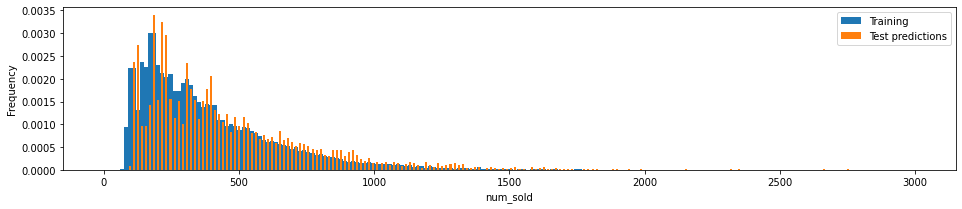

In [7]:
if len(test_pred_list) > 0:
    # Create the submission file
    sub = original_test_df[['row_id']].copy()
    sub['num_sold'] = sum(test_pred_list) / len(test_pred_list)
    sub.to_csv('submission.csv', index=False)

    # Plot the distribution of the test predictions
    plt.figure(figsize=(16,3))
    plt.hist(train_df['num_sold'], bins=np.linspace(0, 3000, 201), density=True, label='Training')
    plt.hist(sub['num_sold'], bins=np.linspace(0, 3000, 201), density=True, rwidth=0.5, label='Test predictions')
    #plt.xticks(ticks=range(1, 8), labels=[f"{i}\n{(sub['Cover_Type'] == i).mean():.5f}" for i in range(1, 8)])
    plt.xlabel('num_sold')
    plt.ylabel('Frequency')
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.legend()
    plt.show()

    sub